# CrowdTruth for Free Input Tasks: Person Annotation in Video

In this tutorial, we will apply CrowdTruth metrics to a **free input** crowdsourcing task for **Person Annotation** from **video fragments**. The workers were asked to watch a video of about 3-5 seconds and then add tags that are relevant for the people that appear in the video fragment. The task was executed on [FigureEight](https://www.figure-eight.com/). For more crowdsourcing annotation task examples, click [here](https://raw.githubusercontent.com/CrowdTruth-core/tutorial/getting_started.md).

To replicate this experiment, the code used to design and implement this crowdsourcing annotation template is available here: [template](https://raw.githubusercontent.com/CrowdTruth/CrowdTruth-core/master/tutorial/templates/People-Video-Free/template.html), [css](https://raw.githubusercontent.com/CrowdTruth/CrowdTruth-core/master/tutorial/templates/People-Video-Free/template.css), [javascript](https://raw.githubusercontent.com/CrowdTruth/CrowdTruth-core/master/tutorial/templates/People-Video-Free/template.js). 

This is a screenshot of the task as it appeared to workers:

![Task Template](../img/person-video-free-input.png)

A sample dataset for this task is available in [this file](https://raw.githubusercontent.com/CrowdTruth/CrowdTruth-core/master/tutorial/data/person-video-free-input.csv), containing raw output from the crowd on FigureEight. Download the file and place it in a folder named `data` that has the same root as this notebook. Now you can check your data:

In [4]:
import pandas as pd

test_data = pd.read_csv("../data/crowdtruth.csv")
test_data.head()

,_unit_id,_created_at,_id,_started_at,_worker_id,keywords,dummy
0,1271340,1/1/2020 00:02:00,0,1/1/2020 00:00:00,2,"[""firefox70"",""css""]",dummy
1,1271340,1/1/2020 00:02:00,1,1/1/2020 00:00:00,6,"[""completely-disable-enhanced-tracking-protect...",dummy
2,1271334,1/1/2020 00:02:00,2,1/1/2020 00:00:00,2,"[""downgrade"",""ubuntu""]",dummy
3,1271334,1/1/2020 00:02:00,3,1/1/2020 00:00:00,6,"[""downgrade"",""firefox"",""discard"",""go-back-to-p...",dummy
4,1271333,1/1/2020 00:02:00,4,1/1/2020 00:00:00,2,"[""restart"",""windows 10"",""firefox-69.0.3"",""rest...",dummy


## Declaring a pre-processing configuration

The pre-processing configuration defines how to interpret the raw crowdsourcing input. To do this, we need to define a configuration class. First, we import the default CrowdTruth configuration class:

In [5]:
import crowdtruth
from crowdtruth.configuration import DefaultConfig

Our test class inherits the default configuration `DefaultConfig`, while also declaring some additional attributes that are specific to the Person Type/Role Annotation in Video task:

* **`inputColumns`:** list of input columns from the .csv file with the input data
* **`outputColumns`:** list of output columns from the .csv file with the answers from the workers
* **`annotation_separator`:** string that separates between the crowd annotations in `outputColumns`
* **`open_ended_task`:** boolean variable defining whether the task is open-ended (i.e. the possible crowd annotations are not known beforehand, like in the case of free text input); in the task that we are processing, workers pick the answers from a pre-defined list, therefore the task is not open ended, and this variable is set to `False`
* **`annotation_vector`:** list of possible crowd answers, mandatory to declare when `open_ended_task` is `False`; for our task, this is the list of relations
* **`processJudgments`:** method that defines processing of the raw crowd data; for this task, we process the crowd answers to correspond to the values in `annotation_vector`

Same examples of possible processing functions of crowd answers are given below:

In [6]:
!pip install nltk
!pip install autocorrect

In [7]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from autocorrect import spell

def correct_words(keywords, separator):
    keywords_list = keywords.split(separator)
    corrected_keywords = []
    
    for keyword in keywords_list:
        
        words_in_keyword = keyword.split(" ")
        corrected_keyword = []
        for word in words_in_keyword:
            correct_word = spell(word)
            corrected_keyword.append(correct_word)
        corrected_keywords.append(" ".join(corrected_keyword))
    return separator.join(corrected_keywords)
    
def cleanup_keywords(keywords, separator):
    keywords_list = keywords.split(separator)
    stopset = set(stopwords.words('english'))
    
    filtered_keywords = []
    for keyword in keywords_list:
        tokens = nltk.word_tokenize(keyword)
        cleanup = " ".join(filter(lambda word: str(word) not in stopset or str(word) == "no" or str(word) == "not", keyword.split()))
        filtered_keywords.append(cleanup)
    return separator.join(filtered_keywords)

def nltk2wn_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_keywords(keywords, separator):
    keywords_list = keywords.split(separator)
    lematized_keywords = []
    
    for keyword in keywords_list:
        nltk_tagged = nltk.pos_tag(nltk.word_tokenize(str(keyword)))  
        wn_tagged = map(lambda x: (str(x[0]), nltk2wn_tag(x[1])), nltk_tagged)
        res_words = []
        for word, tag in wn_tagged:
            if tag is None:            
                res_word = wordnet._morphy(str(word), wordnet.NOUN)
                if res_word == []:
                    res_words.append(str(word))
                else:
                    if len(res_word) == 1:
                        res_words.append(str(res_word[0]))
                    else:
                        res_words.append(str(res_word[1]))
            else:
                res_word = wordnet._morphy(str(word), tag)
                if res_word == []:
                    res_words.append(str(word))
                else: 
                    if len(res_word) == 1:
                        res_words.append(str(res_word[0]))
                    else:
                        res_words.append(str(res_word[1]))
        
        lematized_keyword = " ".join(res_words)
        lematized_keywords.append(lematized_keyword)
        
    return separator.join(lematized_keywords)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/wfenton/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/wfenton/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/wfenton/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/wfenton/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


The complete configuration class is declared below:

In [13]:
class TestConfig(DefaultConfig):
    inputColumns = []
    outputColumns = ["keywords"]
    customPlatformColumns = []
    
    # processing of a closed task
    open_ended_task = True
    annotation_vector = []
    
    def processJudgments(self, judgments):
        # pre-process output to match the values in annotation_vector
        for col in self.outputColumns:
            # transform to lowercase
            judgments[col] = judgments[col].apply(lambda x: str(x).lower())
            # remove square brackets from annotations
            judgments[col] = judgments[col].apply(lambda x: str(x).replace('[]','no tags'))
            judgments[col] = judgments[col].apply(lambda x: str(x).replace('[',''))
            judgments[col] = judgments[col].apply(lambda x: str(x).replace(']',''))
            # remove the quotes around the annotations
            judgments[col] = judgments[col].apply(lambda x: str(x).replace('"',''))
            # apply custom processing functions
#             judgments[col] = judgments[col].apply(lambda x: correct_words(str(x), self.annotation_separator))
#             judgments[col] = judgments[col].apply(lambda x: "no tag" if cleanup_keywords(str(x), self.annotation_separator) == '' else cleanup_keywords(str(x), self.annotation_separator))
#             judgments[col] = judgments[col].apply(lambda x: lemmatize_keywords(str(x), self.annotation_separator))
        return judgments

## Pre-processing the input data

After declaring the configuration of our input file, we are ready to pre-process the crowd data:

In [14]:
data, config = crowdtruth.load(
    file = "../data/crowdtruth.csv",
    config = TestConfig()
)

data['judgments'].head()

,output.keywords,output.keywords.count,output.keywords.unique,unit,worker,started,submitted,duration,job
judgment,,,,,,,,,
0,"{'firefox70': 1, 'css': 1}",2,2,1271340,2,2020-01-01,2020-01-01 00:02:00,120,../data/crowdtruth
1,{'completely-disable-enhanced-tracking-protect...,7,7,1271340,6,2020-01-01,2020-01-01 00:02:00,120,../data/crowdtruth
2,"{'downgrade': 1, 'ubuntu': 1}",2,2,1271334,2,2020-01-01,2020-01-01 00:02:00,120,../data/crowdtruth
3,"{'downgrade': 1, 'firefox': 1, 'discard': 1, '...",8,8,1271334,6,2020-01-01,2020-01-01 00:02:00,120,../data/crowdtruth
4,"{'restart': 1, 'windows 10': 1, 'firefox-69.0....",4,4,1271333,2,2020-01-01,2020-01-01 00:02:00,120,../data/crowdtruth


## Computing the CrowdTruth metrics

The pre-processed data can then be used to calculate the CrowdTruth metrics:

In [15]:
results = crowdtruth.run(data, config)

`results` is a dict object that contains the quality metrics for the video fragments, annotations and crowd workers.

The **video fragment metrics** are stored in `results["units"]`:

In [19]:
results["units"].sort_values("uqs", ascending=False)

,duration,job,output.keywords,output.keywords.annotations,output.keywords.unique_annotations,worker,uqs,unit_annotation_score,uqs_initial,unit_annotation_score_initial
unit,,,,,,,,,,
1274645,120,../data/crowdtruth,"{'off-topic': 3, 'email': 1}",4,2,3,0.863824,"{'off-topic': 1.0, 'email': 0.17809501225752017}",0.804738,"{'off-topic': 1.0, 'email': 0.3333333333333333}"
1271137,120,../data/crowdtruth,"{'firefox': 2, 'password': 2, 'sync': 2, '': 2...",10,6,2,0.816497,"{'firefox': 1.0, 'password': 1.0, 'sync': 1.0,...",0.816497,"{'firefox': 1.0, 'password': 1.0, 'sync': 1.0,..."
1276763,120,../data/crowdtruth,"{' deleted': 1, 'profile': 3, 'windows7': 2, '...",12,7,3,0.609124,"{' deleted': 0.3769301327267123, 'profile': 1....",0.599720,"{' deleted': 0.3333333333333333, 'profile': 1...."
1276809,120,../data/crowdtruth,"{'upload': 2, 'quit': 2, 'warning': 2, 'add-fe...",11,8,2,0.566947,"{'upload': 1.0, 'quit': 1.0, 'warning': 1.0, '...",0.566947,"{'upload': 1.0, 'quit': 1.0, 'warning': 1.0, '..."
1271065,120,../data/crowdtruth,"{'windows-8.1': 1, 'firefox': 2, 'thunderbird'...",11,8,2,0.566947,"{'windows-8.1': 0.5165612626291611, 'firefox':...",0.566947,"{'windows-8.1': 0.5, 'firefox': 1.0, 'thunderb..."
...,...,...,...,...,...,...,...,...,...,...
1274678,120,../data/crowdtruth,"{'': 1, 'desktop': 1, '71': 1, 'addon': 1, 'pr...",9,9,3,0.000000,"{'': 0.41041291588409706, 'desktop': 0.4114920...",0.000000,"{'': 0.3333333333333333, 'desktop': 0.33333333..."
1271218,120,../data/crowdtruth,"{'firefox 70': 1, 'tabs-width': 1, '70': 1, 'w...",10,10,2,0.000000,"{'firefox 70': 0.48842971215859265, 'tabs-widt...",0.000000,"{'firefox 70': 0.5, 'tabs-width': 0.5, '70': 0..."
1274684,120,../data/crowdtruth,"{'opening-documents': 1, '': 1, 'desktop': 1, ...",7,7,3,0.000000,"{'opening-documents': 0.41041291588409706, '':...",0.000000,"{'opening-documents': 0.3333333333333333, '': ..."


The `uqs` column in `results["units"]` contains the **video fragment quality scores**, capturing the overall workers agreement over each video fragment. Here we plot its histogram:

Text(0, 0.5, 'Number of Tickets')

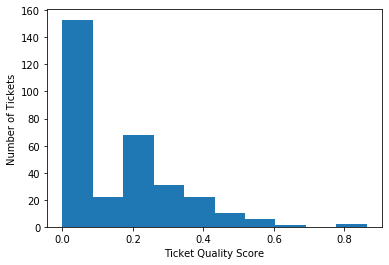

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(results["units"]["uqs"])
plt.xlabel("Ticket Quality Score")
plt.ylabel("Number of Tickets")

The `unit_annotation_score` column in `results["units"]` contains the **video fragment-annotation scores**, capturing the likelihood that an annotation is expressed in a video fragment. For each video fragment, we store a dictionary mapping each annotation to its video fragment-relation score.

In [23]:
results["units"]["unit_annotation_score"]

unit
1271065    {'windows-8.1': 0.5165612626291611, 'firefox':...
1271066    {'mac-os-10.6.8': 0.5165612626291611, 'firefox...
1271071    {'non-english': 0.5165612626291611, 'ruassian'...
1271072    {'firefox': 1.0, 'others': 0.5165612626291611,...
1271073    {'firefox': 1.0, 'firefox-69.03': 0.5165612626...
                                 ...                        
1276839    {'ui': 1.0, 'request': 0.46552509530979885, 'q...
1276840    {'report': 0.46552509530979885, 'error': 1.0, ...
1276841    {'authorize': 0.46552509530979885, 'expired': ...
1276842    {'reboot': 0.46552509530979885, 'windows-7': 0...
1276843    {'ssr': 0.46552509530979885, 'css': 0.46552509...
Name: unit_annotation_score, Length: 315, dtype: object

The **worker metrics** are stored in `results["workers"]`:

In [27]:
results["workers"].sort_values("wsa", ascending=False)

,unit,judgment,job,duration,wqs,wwa,wsa,wqs_initial,wwa_initial,wsa_initial
worker,,,,,,,,,,
8,54,54,1,120,0.224123,0.433214,0.517351,0.014569,0.106377,0.136953
4,52,52,1,120,0.223536,0.435931,0.512777,0.013066,0.101425,0.128828
1,63,63,1,120,0.135712,0.333303,0.407174,0.072541,0.238658,0.303954
7,100,100,1,120,0.119901,0.321353,0.373113,0.046228,0.201143,0.229829
3,100,100,1,120,0.104433,0.302577,0.345145,0.038541,0.186346,0.206827
9,54,54,1,120,0.097001,0.289279,0.335321,0.013355,0.102184,0.130693
5,80,80,1,120,0.111606,0.334075,0.334075,0.011482,0.107152,0.107152
6,161,161,1,120,0.104450,0.323435,0.322939,0.018552,0.136208,0.136208
2,81,81,1,120,0.099725,0.315793,0.315793,0.027193,0.164904,0.164904


The `wqs` columns in `results["workers"]` contains the **worker quality scores**, capturing the overall agreement between one worker and all the other workers.

`wwa` - worker worker agreement

`wws` - worker sentence agreement

Text(0, 0.5, 'Number of Taggers')

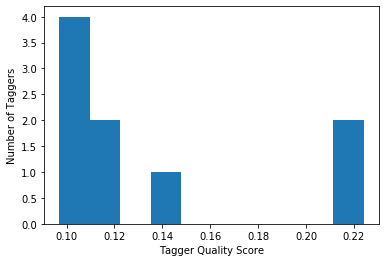

In [32]:
plt.hist(results["workers"]["wqs"])
plt.xlabel("Tagger Quality Score")
plt.ylabel("Number of Taggers")